Connected to cswe (Python 3.11.5)

### Processing the original data set of BIPOC researchers in social work and their research interests.
The data is unstructured and needs to be "cleaned" before attempting to extract meaningful information. In this context, cleaned means removing duplicates, plurals, and mispelling. Since the information is made of terms that may be single words or multi-word phrases, using simple term frequency does not work as well as trying to extract word combinations based on their distance from each other in the text and their frequency.  

In [16]:
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
import pandas as pd
import pkg_resources
import numpy as np
import nltk
from textblob import TextBlob
from symspellpy import SymSpell, Verbosity
from joblib import Parallel, delayed
import os
import openpyxl
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [17]:
data = pd.read_csv('original_data.csv')

#### Settings for implementing the spell checking and word combination extraction. 

In [18]:
def initialize_symspell(max_dictionary_edit_distance=2, prefix_length=7):
    sym_spell = SymSpell(max_dictionary_edit_distance=max_dictionary_edit_distance, prefix_length=prefix_length)
    dictionary_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_dictionary_en_82_765.txt")
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    return sym_spell

sym_spell = initialize_symspell()

def apply_sym_spell_correction(text):
    # Handle non-string data
    if not isinstance(text, str):
        return text
    corrected_text = sym_spell.lookup(text, Verbosity.CLOSEST)
    if corrected_text:
        return corrected_text[0].term
    return text  # if no correction is found, return the original text

def correct_spelling_with_symspell(df: pd.DataFrame) -> pd.DataFrame:
    #Remember there's nan and have to be strings 
    df = df.astype(str).fillna('')
    # Corrects spelling for all entries in the DataFrame using SymSpell
    for col in df.columns:
        df[col] = df[col].apply(apply_sym_spell_correction)
    return df


In [19]:
corrected_data = correct_spelling_with_symspell(data)

#### Settings to find the most common word combinations in the data set with a focus on bigrams or two-word phrases.

In [20]:
tokenized_interests = [simple_preprocess(doc) for doc in corrected_data['Interests']]
# Find some useful words with Gensim's Phrases
phrases = Phrases(tokenized_interests, min_count=3, threshold=20)
phraser = Phraser(phrases)

In [21]:
# Check if it makes sense
list(phraser.phrasegrams.keys())

['african_americans',
 'welfare_reform',
 'program_evaluation',
 'cross_cultural',
 'child_welfare',
 'kinship_care',
 'african_american',
 'substance_abuse',
 'community_based',
 'based_participatory',
 'participatory_research',
 'criminal_justice',
 'hiv_aids',
 'access_to',
 'quantitative_methods',
 'suicide_prevention',
 'hiv_prevention',
 'child_maltreatment',
 'domestic_violence',
 'ethnic_minority',
 'data_analysis',
 'violence_against',
 'against_women',
 'race_ethnicity',
 'substance_use',
 'early_childhood',
 'racial_ethnic',
 'risk_behaviors',
 'human_trafficking',
 'culturally_competent',
 'serious_mental',
 'ethnic_minorities',
 'young_adult',
 'partner_violence',
 'provider_communication',
 'decision_making',
 'vulnerable_populations',
 'focusing_on',
 'well_being',
 'an_emphasis',
 'emphasis_on',
 'intimate_partner',
 'evidence_based',
 'critical_race',
 'race_theory',
 'contextual_factors',
 'integrated_behavioral',
 'problem_behaviors',
 'mass_incarceration',
 'human_r

The output can be manually reviewed to check for filler words or stopwords and adjusting the spellchecking and grouping settings. Since it's a small data set with specialized terms, it's preferable to make the list of filler words than using pre-made lists.

In [22]:
# retry with stopwords after reviewing output
stopwords = set(["that", "this", "these", "to", "as", "such", "by", "focus", "on", "with", "the", "an", "at", "emphasis"])


In [23]:
# Repeat the tokenization with the new stopwords
tokenized_interests = [[word for word in simple_preprocess(doc) if word not in stopwords] for doc in corrected_data['Interests']]
phrases = Phrases(tokenized_interests, min_count=3, threshold=20)
phraser = Phraser(phrases)

In [24]:
# Check if it makes sense
list(phraser.phrasegrams.keys())

['african_americans',
 'welfare_reform',
 'program_evaluation',
 'cross_cultural',
 'child_welfare',
 'kinship_care',
 'african_american',
 'substance_abuse',
 'community_based',
 'based_participatory',
 'participatory_research',
 'criminal_justice',
 'hiv_aids',
 'quantitative_methods',
 'suicide_prevention',
 'child_maltreatment',
 'domestic_violence',
 'ethnic_minority',
 'data_analysis',
 'violence_against',
 'against_women',
 'race_ethnicity',
 'substance_use',
 'early_childhood',
 'racial_ethnic',
 'risk_behaviors',
 'human_trafficking',
 'culturally_competent',
 'serious_mental',
 'ethnic_minorities',
 'young_adult',
 'partner_violence',
 'provider_communication',
 'decision_making',
 'vulnerable_populations',
 'well_being',
 'intimate_partner',
 'evidence_based',
 'critical_race',
 'race_theory',
 'contextual_factors',
 'integrated_behavioral',
 'problem_behaviors',
 'mass_incarceration',
 'human_rights',
 'sex_trafficking',
 'adverse_childhood',
 'childhood_experiences',
 'ser

In [25]:
# Check how many phrases we have
len(phraser.phrasegrams.keys())


112

Export the results to a spreadsheet file 

In [26]:
phrased_interests = phraser.phrasegrams.keys()

In [13]:
# Convert the phrased_interests back to string format
taxonomy_series = [' '.join(interest) for interest in phrased_interests]

# Create a DataFrame
taxonomy_df = pd.DataFrame(taxonomy_series, columns=["taxonomy"])

# Write to Excel
taxonomy_df.to_excel("taxonomy_output.xlsx", index=False)


<strong>To do</strong>
#### Connect the taxonomy back to the researchers
Now there's more research interests than researchers in the data set. The goal is to link researchers to multiple items in the taxonomy by finding similarities between the original data and the new taxonomy terms. 

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import sent_tokenize


In [31]:
# Correct spelling for the 'interests' column again and filler text for empty values if any

data['Name'].fillna('not specified', inplace=True)
researchers = data['Name'].tolist()

corrected_interests = data['Interests'].apply(apply_sym_spell_correction).fillna('not specified')

# List of all texts: taxonomy and corrected_interests
all_texts = taxonomy_series + corrected_interests.tolist()

# Filter out any invalid entries
all_texts = [text for text in all_texts if text and not pd.isna(text)]

# find frequent and unique words, turn into vectors
vectorizer = TfidfVectorizer().fit(all_texts)
tfidf_matrix = vectorizer.transform(all_texts)

#  Make vectors of taxonomy and interests separately
taxonomy_vectors = tfidf_matrix[:len(taxonomy_series)]
interests_vectors = tfidf_matrix[len(taxonomy_series):]

researcher_taxonomy_mapping = []


In [32]:
# Tokenize the interests into sentences or chunks
interest_sentences = [sent_tokenize(interest) for interest in corrected_interests]

# Flatten the list and associate each sentence with its researcher
researcher_sentence_pairs = [(researcher, sentence) for researcher, sentences in zip(researchers, interest_sentences) for sentence in sentences]

# For each sentence, calculate similarity with taxonomy items and store the top 3 similar taxonomy items

vectorizer = TfidfVectorizer().fit(all_texts)
tfidf_matrix = vectorizer.transform(all_texts)

# Separate vectors
taxonomy_vectors = tfidf_matrix[:len(taxonomy_series)]
sentence_vectors = vectorizer.transform([pair[1] for pair in researcher_sentence_pairs])




/Applications/anaconda3/envs/cswe/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


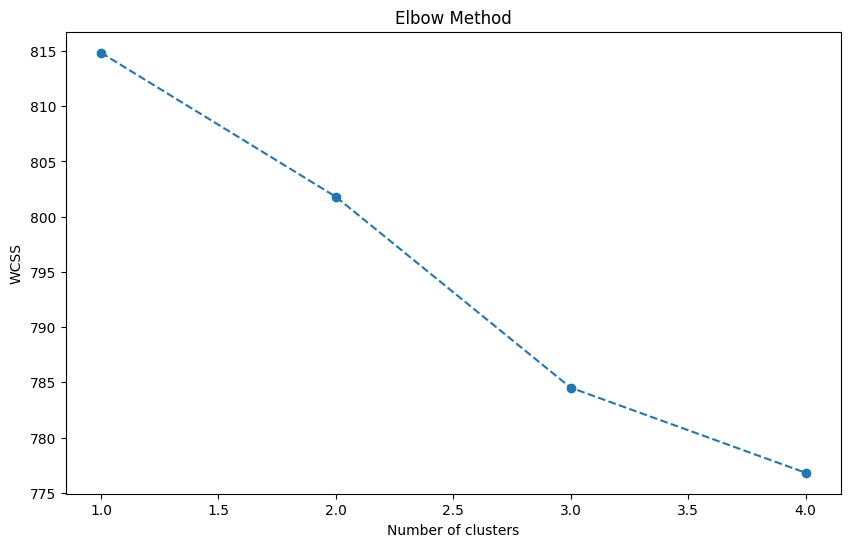

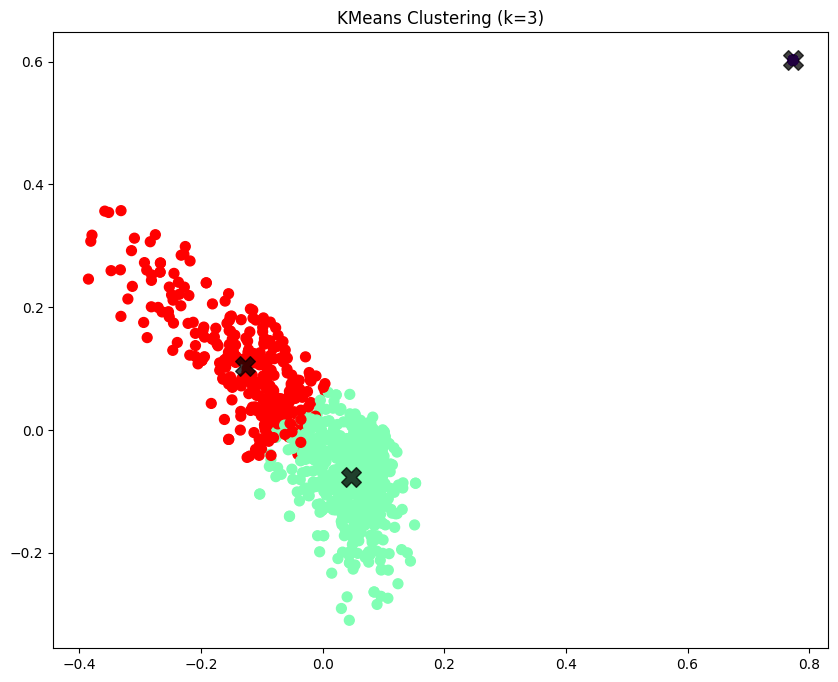

In [49]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# Apply PCA and reduce the data's dimensions to 2
pca = PCA(n_components=800)
reduced_vectors = pca.fit_transform(interests_vectors.toarray())

# Step 1: Use KMeans clustering with a range of `k` values
wcss = []  # Within-cluster sum of squares
K_range = range(1, 5)  # Let's check for up to 15 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(interests_vectors)
    wcss.append(kmeans.inertia_)

# Step 2: Calculate the sum of squared distances for each `k`
# Step 3: Plot the elbow curve
plt.figure(figsize=(10,6))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Based on the graph, you can pick the 'k' where the rate of decrease sharply changes, creating an "elbow" in the graph.

# Once you've chosen the 'k', you can then use it to cluster and visualize as before.
chosen_k = int(input("Enter the chosen k based on the graph: "))  # e.g., 4 or 5, depending on where you see the "elbow"

kmeans = KMeans(n_clusters=chosen_k, random_state=42)
clusters = kmeans.fit_predict(interests_vectors)

# Visualize
plt.figure(figsize=(10, 8))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=clusters, cmap='rainbow', s=50)
centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75, marker='X')
plt.title(f"KMeans Clustering (k={chosen_k})")
plt.show()



#### Visualizations

In [70]:
print(len(researchers))

862
